In [1]:
import json
import numpy as np 
from collections import defaultdict 

In [2]:
def read_file(path):
    data_by_src = defaultdict(list)
    with open(path, "r") as f1:
        for line in f1:
            line = json.loads(line)
            # trim off last token (EOS)
            line['logit_at_label'] = np.array(line['logit_at_label'][0:-1])
            data_by_src[line['natural']].append(line)

    # for src, list_ in data_by_src.items():
        # assert(len(list_) == 2)

    return data_by_src


In [3]:
data_for_df = []

for model in ["codegen-350M", "codegen-2B", "codegen-6B", "codegen-16B"]:
    for t in ['pp', 'scope', 'revscope', 'bound', 'conj']:
        
        path = f"/brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/{model}/{t}_fol/outputs/test_eval.logits"
        print(f"reading {path}")
        try:
            data_by_src = read_file(path)
        except FileNotFoundError:
            print(f"file not found: {path}")
            continue

        for src, lines in data_by_src.items():
            p_lf0, p_lf1 = None, None
            min_lf0, min_lf1 = None, None
            for line in lines:
                template_idx = str(line['template_idx'])
                total_prob = np.exp(np.sum(np.log(line['logit_at_label'])))

                min_logit_at_label = np.min(line['logit_at_label']) 
                if template_idx == '0':
                    min_lf0 = min_logit_at_label
                    p_lf0 = total_prob
                else:
                    min_lf1 = min_logit_at_label
                    p_lf1 = total_prob

            # turn into a proper probability by normalizing 
            norm_min_p_lf0 = min_lf0 / (min_lf0 + min_lf1)
            norm_total_p_lf0 = p_lf0 / (p_lf0 + p_lf1)

            data_for_df.append({"model": model, "amb_type": t,  "type": "norm_min_lf0", "value": norm_min_p_lf0}) 
            data_for_df.append({"model": model, "amb_type": t,  "type": "norm_total_lf0", "value": norm_total_p_lf0}) 


reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/pp_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/scope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/revscope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/bound_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/conj_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/pp_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/scope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/revscope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/bound_fol/outputs/test_eval

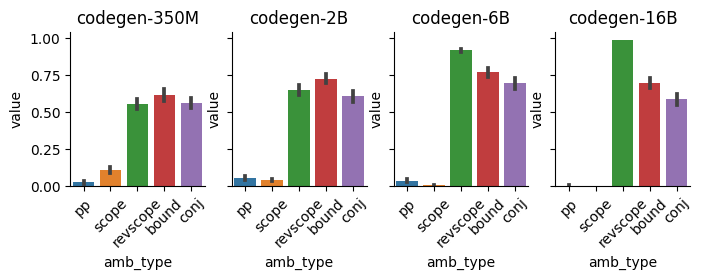

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt 
import pandas as pd

df = pd.DataFrame(data_for_df)

prob_df = df[df['type'] == "norm_total_lf0"]

fig, ax = plt.subplots(1, 4, figsize=(8,2), sharex=True, sharey=True)

for midx, model in enumerate(["codegen-350M", "codegen-2B", "codegen-6B", "codegen-16B"]):
    ax[midx].set_title(model)
    model_df = df[df['model'] == model]  
    sns.barplot(data = model_df, x = "amb_type", y = "value", ax=ax[midx])
    # rotate xticks 45 degrees
    for item in ax[midx].get_xticklabels():
        item.set_rotation(45)

sns.despine()


array([0.56487673, 0.99919729, 0.98572448, 0.94531169, 0.71446648,
       0.87121185, 0.99614787, 0.91052998, 0.99388688, 0.99529606,
       0.80777776, 0.99971648, 0.99861005, 0.999393  , 0.9693878 ,
       0.66453262, 0.99987866, 0.99541357, 0.99958687, 0.99441353,
       0.98799894, 0.99988831, 0.99890352, 0.99201467, 0.98092263,
       0.98070347, 0.9998124 , 0.99735876, 0.99872918, 0.99586416,
       0.99895396, 0.99385308, 0.99905711, 0.99987079, 0.99986901,
       0.99955936, 0.99917492, 0.99870611])